Final Project

Katie Hippe

ATM S 380

March 19, 2025

In [2]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io

# load in the hadcrut5 
hadcrut5full = io.loadmat('HadCRUT5.mat', squeeze_me = True)
t_had = hadcrut5full['T_HadCRUT5']

# and the R forcing data stuff 
forcingdata = io.loadmat('HistoricalForcings.mat', squeeze_me = True)
year = forcingdata['year']
RCO2 = forcingdata['RCO2'] # can use this to double check my co2 function 
RCH4 = forcingdata['RCH4']
RN2O = forcingdata['RN2O']
Rother = forcingdata['Rother']
Raerosol = forcingdata['Raerosol']
Rvolcanic = forcingdata['Rvolcanic']

First, here is all the stuff from homework 2

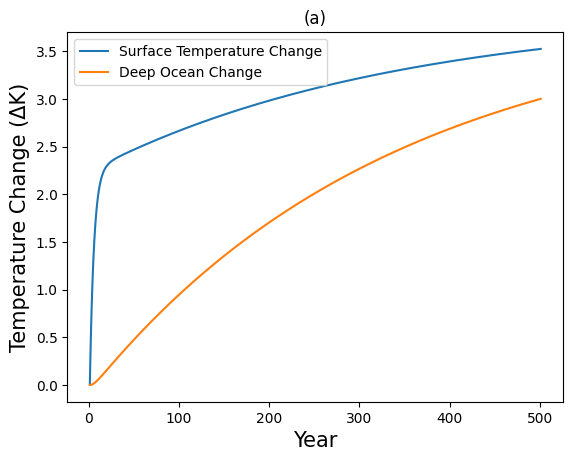

In [3]:
# define function for looping through our differential equations 
def twolayerEMB (t_init,t_final, delta_t, T_0, TO_0, CS, CO, Rf, l, g):
    curr_T = T_0
    curr_TO = TO_0

    T = [curr_T]
    TO = [curr_TO]

    for t in range(t_init, t_final + 1):
        # delta t = 3.154e7 lazy hardcoding
        next_T = curr_T + (3.1536e7 / CS) * (Rf[t - t_init] + l * curr_T - g * (curr_T - curr_TO))
        next_TO = curr_TO + (3.1537e7 / CO) * g * (curr_T - curr_TO)

        curr_T = next_T
        curr_TO = next_TO 

        T.append(curr_T)
        TO.append(curr_TO)

    return T, TO

# set up our inputs 
T_0, TO_0 = 0,0
t_init = 1
t_final = 500
deltat = 1
Rf = np.full((t_final+1), 3.9) # make an array for ease down the line 
CS = 1025 * 3850 * 70 # lazy hard-coding
CO = 1025 * 3850 * 1100
l = -1
g = .7

# run our model over 500 years 
T, TO = twolayerEMB(t_init, t_final, 1, T_0, TO_0, CS, CO, Rf, l, g)

# plotting function (for laziness purposes)

def plotT(t_init, t_final, deltat, T, TO, historical, title):
    # axis for plotting purposes
    axis = np.arange(t_init, t_final+2, deltat)

    # plot stuff!
    plt.plot(axis,T, label="Surface Temperature Change")
    plt.plot(axis, TO, label="Deep Ocean Change")
    if historical:
        plt.plot(np.arange(1850,2023, 1), t_had, label="HadCRUT5") # hard-coded in bc i'm lazy 
    plt.xlabel("Year", fontsize = 15)
    plt.ylabel(u'Temperature Change (ΔK)', fontsize = 15)
    plt.legend(loc="upper left")
    plt.title(title)
    plt.show()

# plot our T!
plotT(t_init, t_final, deltat, T, TO, False, '(a)')


Now we define our carbon cycling function: given any emissions scenario (E), this will calculate the projected carbon still in the atmosphere over the timeline specified by t_init to t_final

In [4]:
# constants for the Joos function 
a0, a1, a2, a3 = .217, .259, .338, .186
tau1, tau2, tau3 = 172.9, 18.51, 1.186

# define function for determining the carbon concentrations based on emissions 
def CO2conc(t_init, t_final, deltat, E, C0):

    t_vec = np.arange(t_init, t_final, deltat) # needs to match up with E vec
    C = np.full((t_vec.shape), C0) # same size as t_vec! initially its all the initial concentration

    for t in range(0, t_final-t_init): # loop through our emissions data 
        e = E[t] # this is our pulse 
        curr_C = np.full((C.shape), 0.0)

        for ti in range(t, t_final-t_init): # lots of index finagling 

            joos = e*(a0 + (a1*np.exp(-(ti - t)/tau1))  +
                                (a2*np.exp(-(ti - t)/tau2)) + 
                                (a3*np.exp(-(ti - t)/tau3))) # joos function - C0
            
            curr_C[ti] = joos

        C = C + curr_C

    return C




Start testing it!

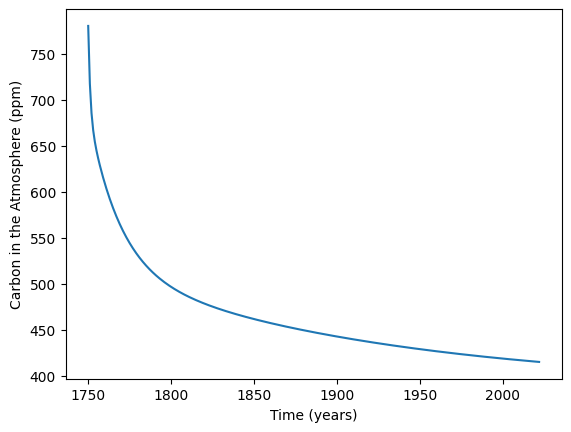

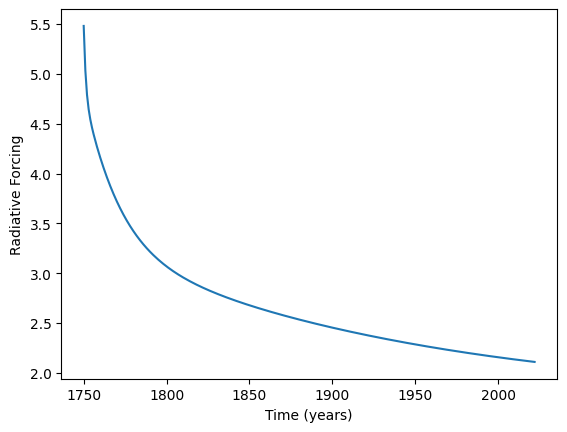

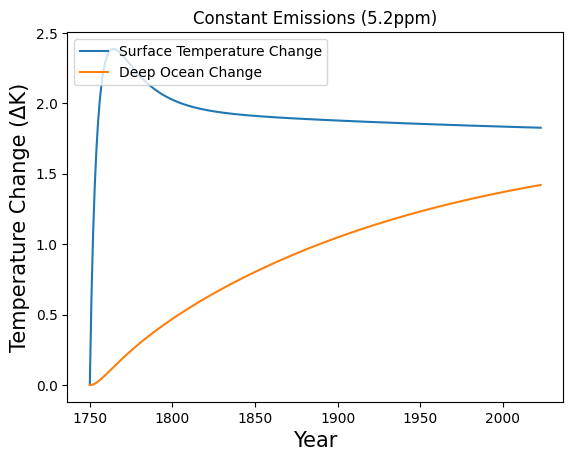

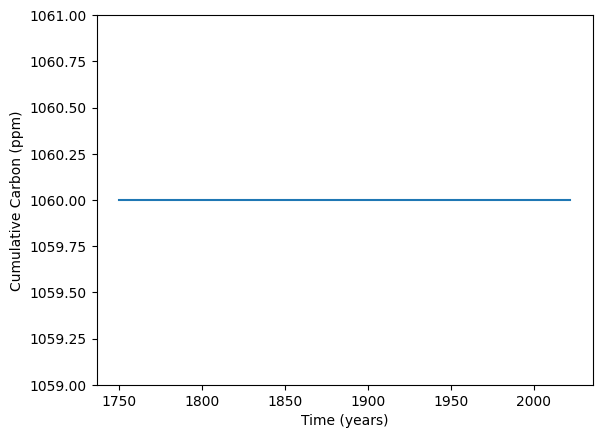

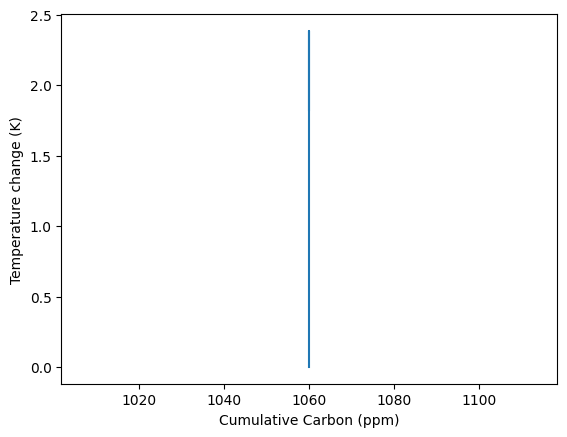

In [89]:
C0 = 280
E = np.full((t_final-t_init+1), 0)
E[0] = 500 # start with the example already given
C = CO2conc(t_init, t_final, deltat, E, C0)

# plot the carbon concentration as a function of emissions
plt.plot(np.arange(t_init, t_final, deltat), C)
plt.xlabel("Time (years)")
plt.ylabel("Carbon in the Atmosphere (ppm)")
plt.show()

# from the carbon concentration, determine the radiative forcing 
Rf = 5.35*np.log(C / C0)
plt.plot(np.arange(t_init, t_final, deltat), Rf)
plt.xlabel("Time (years)")
plt.ylabel("Radiative Forcing")
plt.show()

# finally plot all our data 
T, TO = twolayerEMB(t_init, t_final-1, 1, T_0, TO_0, CS, CO, Rf, l, g)
plotT(t_init, t_final-1, deltat, T, TO, False, "Constant Emissions (5.2ppm)")
plt.show()

# find cumulative sum of carbon emissions
cumC = np.cumsum(E) * 2.12 # from ppm to gtc

# plot the cumulative carbon emissions 
plt.plot(np.arange(t_init, t_final, deltat), cumC[0:273])
plt.ylim(min(cumC) - 1, max(cumC)+1)
plt.xlabel("Time (years)")
plt.ylabel("Cumulative Carbon (ppm)")
plt.show()

plt.plot(cumC[0:272], T[0:272])
plt.xlabel("Cumulative Carbon (ppm)")
plt.ylabel("Temperature change (K)")
plt.show()

Now that we're satisfied the model works with the example we already had (pulse / constant emissions), we can continue on to different emissions scenarios

In [6]:
# get real-life carbon emission data to test our model against!

co2emis = np.genfromtxt('annual-co2-emissions-per-country.csv', delimiter=',')[1:,3]
co2emis = co2emis / 1000000000 
co2emis = co2emis / 7.82

print(np.shape(co2emis))
print(co2emis)

(274,)
[1.19001752e-03 1.20297046e-03 1.21549463e-03 1.22896292e-03
 1.24470332e-03 1.25236164e-03 1.26725243e-03 1.29078465e-03
 1.30643964e-03 1.32210409e-03 1.34454361e-03 1.37440985e-03
 1.40053683e-03 1.43114987e-03 1.45741458e-03 1.48893683e-03
 1.51868031e-03 1.55402928e-03 1.59423734e-03 1.63428056e-03
 1.67483581e-03 1.70965320e-03 1.74213645e-03 1.76574655e-03
 1.79186893e-03 1.83362148e-03 1.87392890e-03 1.91298427e-03
 1.94929450e-03 1.98660294e-03 2.03052762e-03 2.07600806e-03
 2.12032660e-03 2.18193760e-03 2.23415499e-03 2.29733095e-03
 2.35901483e-03 2.41165345e-03 2.46626957e-03 2.54007980e-03
 2.60845192e-03 2.67669437e-03 2.80424731e-03 2.85131202e-03
 2.87975141e-03 2.85361202e-03 2.82882020e-03 2.82481816e-03
 2.95472225e-03 3.51473223e-03 4.19416266e-03 4.09028772e-03
 5.15479233e-03 3.77730256e-03 4.06255448e-03 3.99639616e-03
 4.18217647e-03 4.62923939e-03 4.53935908e-03 4.64626752e-03
 5.05016752e-03 5.13768286e-03 5.21924808e-03 5.26932737e-03
 5.39982737e-03 5

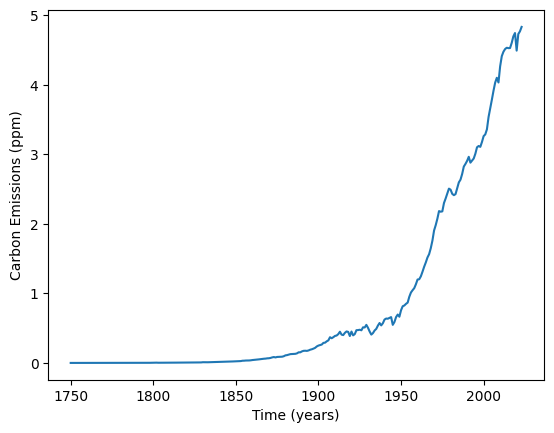

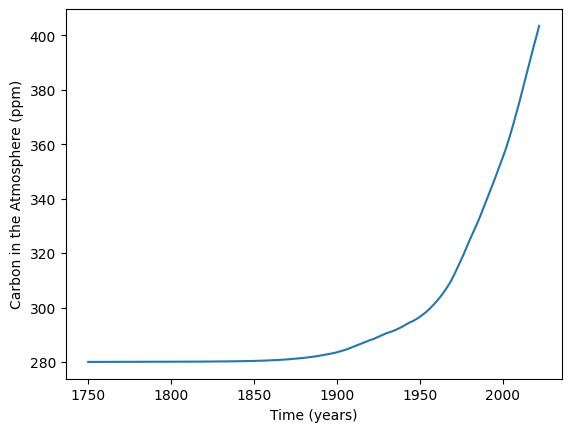

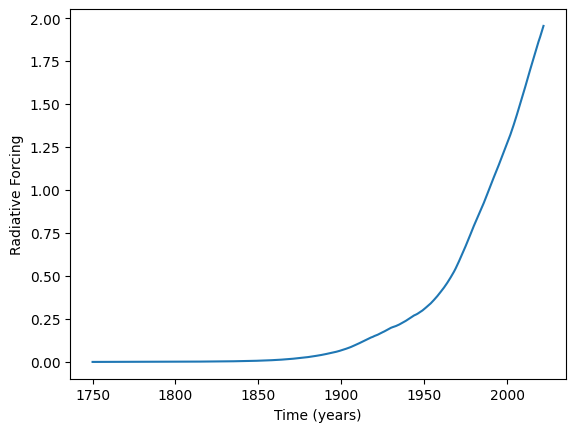

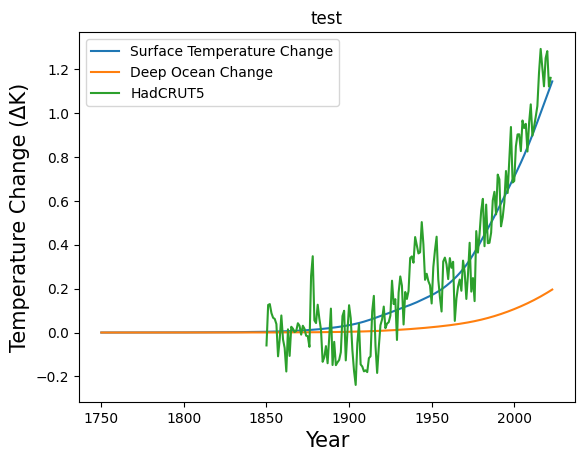

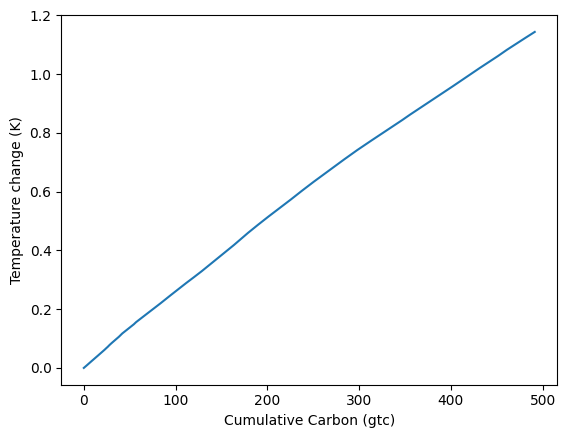

In [66]:
# run model with real-world co2 emission data 

t_init = 1750
t_final = 2023

C0 = 280 # pre-industrial revolution ppm
E = co2emis

plt.plot(np.arange(t_init, t_final+1, deltat), E)
plt.xlabel("Time (years)")
plt.ylabel("Carbon Emissions (ppm)")
plt.show()

# try with instant doubling 
E_inst = np.full((t_final-t_init+1),0)
E_inst[0] = 5.2

C = CO2conc(t_init, t_final, deltat, E, C0)

# plot the carbon concentration as a function of emissions
plt.plot(np.arange(t_init, t_final, deltat), C)
plt.xlabel("Time (years)")
plt.ylabel("Carbon in the Atmosphere (ppm)")
plt.show()

# from the carbon concentration, determine the radiative forcing 
Rf = 5.35*np.log(C / C0)
plt.plot(np.arange(t_init, t_final, deltat), Rf)
plt.xlabel("Time (years)")
plt.ylabel("Radiative Forcing")
plt.show()

# finally plot all our data 
T, TO = twolayerEMB(t_init, t_final-1, 1, T_0, TO_0, CS, CO, Rf, l, g)
plotT(t_init, t_final-1, deltat, T, TO, True, "test")
plt.show()

# find cumulative sum of carbon emissions
cumC = np.cumsum(E) * 2.12 # from ppm to gtc

plt.plot(cumC, T)
plt.xlabel("Cumulative Carbon (gtc)")
plt.ylabel("Temperature change (K)")
plt.show()

A quick comparison between our projected forcing and the Rf data we were given in homework 2

(336,)
(273,)


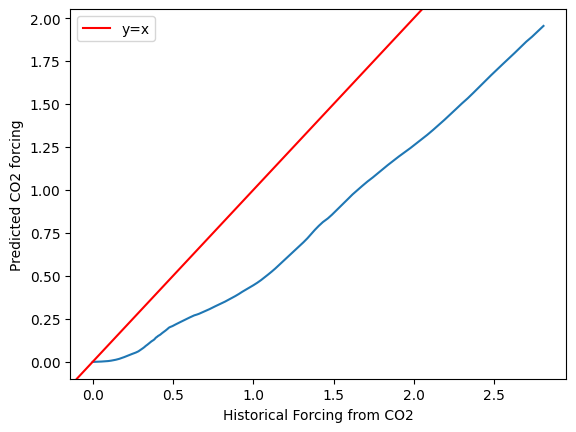

In [8]:
# looking pretty good so far, now we can look at the actual forcing

print(np.shape(RCO2))
print(np.shape(Rf))

RCO2_short = RCO2[:273]

fig, ax = plt.subplots()

ax.plot(RCO2_short, Rf)
ax.set_xlabel("Historical Forcing from CO2")
ax.set_ylabel("Predicted CO2 forcing")
ax.axline((0, 0), slope=1, label="y=x", color='r')
ax.legend()
plt.show()

# very correlated! not quite one-to-one :(

Now we turn everything into a function: runCarbonScenario takes in the timeline, emissions scenario, initial atmospheric carbon, and the title of the scenario and outputs a plot of surface temp vs cumulative carbon emissions

<function matplotlib.pyplot.show(close=None, block=None)>

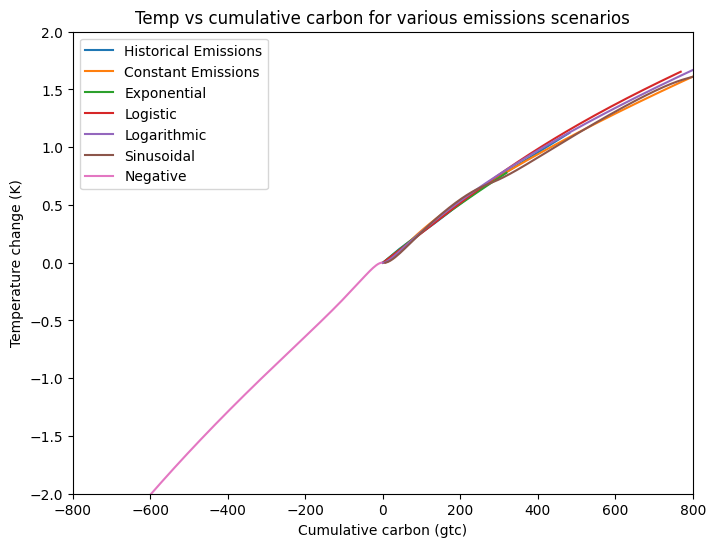

In [111]:
# function?

t_init = 1750
t_final = 2023

C0 = 280 # pre-industrial revolution ppm
E = co2emis

def runCarbonScenario(t_init, t_final, E, C0, title):
    
    C = CO2conc(t_init, t_final, deltat, E, C0)

    # from the carbon concentration, determine the radiative forcing 
    Rf = 5.35*np.log(C / C0)

    # finally plot all our data 
    T, TO = twolayerEMB(t_init, t_final-1, 1, T_0, TO_0, CS, CO, Rf, l, g)
    #plotT(t_init, t_final-1, deltat, T, TO, True, "test")
    #plt.show()

    # find cumulative sum of carbon emissions
    cumC = np.cumsum(E) * 2.12 # from ppm to gtc

    plt.plot(cumC[0:273], T[0:273], label=title)
    #plt.xlabel("Cumulative Carbon (gtc)")
    #plt.ylabel("Temperature change (K)")
    #plt.show()

plt.figure(figsize=(8,6))

# Set the x and y limits of the plot
#plt.xlim(0, 20000)  # x-axis range from 0 to 10
#plt.ylim(-0.5,2) # y-axis range from -5 to 5

# Add labels and title (optional)
plt.xlabel("Cumulative carbon (gtc)")
plt.ylabel("Temperature change (K)")
plt.title("Temp vs cumulative carbon for various emissions scenarios")

# set up our different scenarios
E_const = np.full((t_final-t_init+1), 2)
E_inst = np.full((t_final-t_init+1),0)
E_inst[0] = 5.2

time_vec = np.arange(0,273)
E_exp = 0.001*np.exp(0.031 * time_vec) 

E_log = 5 / (1 + np.exp(-0.1 * (time_vec - 200)))

E_log_2 = 0.8*np.log(time_vec+1)

E_neg = np.full((t_final-t_init+1), -2)
E_sin = np.cos(0.05*time_vec) + 2


titles = ["Historical Emissions", "Constant Emissions", "Exponential", "Logistic", "Logarithmic", "Sinusoidal", "Negative"]
Es = [co2emis, E_const, E_exp, E_log, E_log_2, E_sin,E_neg]


for i in range(len(titles)):
    runCarbonScenario(t_init, t_final, Es[i], C0, titles[i])

plt.xlim(-800,800)
plt.ylim(-2,2)
plt.legend()
plt.show

This splits up our plots (toggle different titles and Es)

<function matplotlib.pyplot.show(close=None, block=None)>

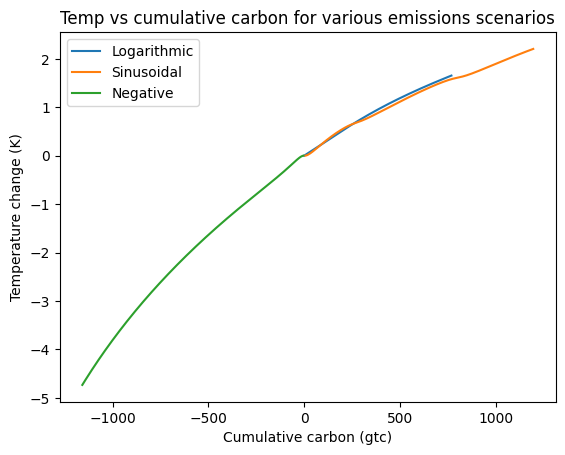

In [113]:
# more 

titles = ["Logarithmic", "Sinusoidal", "Negative"]
Es = [ E_log, E_sin, E_neg]

#titles = ["Historical", "Constant", "Exponential", "Logistic"]
#Es = [co2emis, E_const, E_exp,E_log]

for i in range(len(titles)):
    runCarbonScenario(t_init, t_final, Es[i], C0, titles[i])



plt.xlabel("Cumulative carbon (gtc)")
plt.ylabel("Temperature change (K)")
plt.title("Temp vs cumulative carbon for various emissions scenarios")

#plt.xlim(0,1500)

plt.legend()
plt.show


Finally this compares all our different emissions scenarios against each other to aid our comparison

Text(0.5, 1.0, 'Carbon Emissions Scenarios by Year')

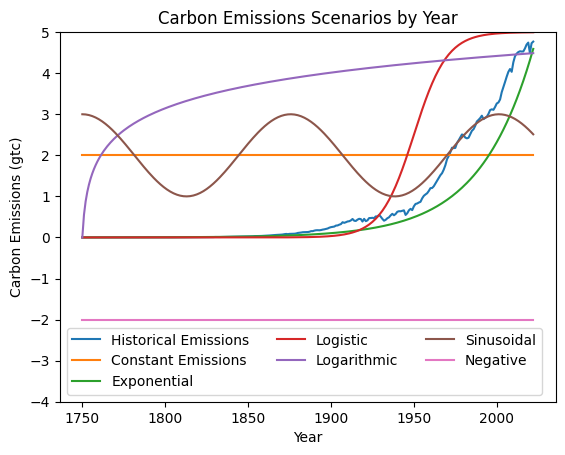

In [117]:
# plot all our different scenarios
titles = ["Historical Emissions", "Constant Emissions", "Exponential", "Logistic", "Logarithmic", "Sinusoidal", "Negative"]
Es = [co2emis, E_const, E_exp, E_log, E_log_2, E_sin,E_neg]

for i in range(len(Es)):
    plt.plot(time_vec + t_init, Es[i][0:273], label = titles[i])

plt.ylim(-4,5)
plt.legend(ncol = 3, loc='lower left')
plt.xlabel("Year")
plt.ylabel("Carbon Emissions (gtc)")
plt.title("Carbon Emissions Scenarios by Year")